# Bias Variance Tradeoff

Let us consider a generating process $y_i=f(x_i)+\epsilon_i$ with $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ which implies that $y_i \sim \mathcal{N}(f(x_i), \sigma^2)$.
Goal is to find a (parametrized) model such that the likelihood of the set of observations $\{(x_i, y_i)\}$ is maximized. For a constant variance of the error, this is equivalent to a minimization of the mean squared error.

We abbreviate $\hat{f}_i := \hat{f}_\theta(x_i)$

We can now compute the (total) mean squared error $MSE(x) = E[(y-\hat{f})^2|x]$ where $E[\cdot|x]$ is the conditional *expectation over several training sets*, at the point $x$.
In the code below we show how to $\color{red}{\text{estimate this expectation value using resamples which are obtained via bootstrap}}$.

It can be shown that the mean squared error can be decomposed:

$MSE(x):= E[(y(x)-\hat{f}(x))^2] = Bias(x)^2 + Var(\hat{f}(x)) +\sigma^2$ holds.

Which is the Bias Variance tradeoff. The bias is computed by $Bias(x)=E[f(x)-\hat{f}(x)]$ and the variance of $\hat{f}$ is computed by $Var(\hat{f}(x)) = E[(\hat{f}(x)-E[\hat{f}(x)])^2]$. $\sigma$ is the intrinsic, "irreducible" uncertainty associated with the noise $\epsilon$.


Normally, the true function $f(x_i)$ is unknown. If this is the case a decomposition of the Bias and the unexplainable noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$ may be beyond the scope. 
Then we can, in a simplifing way, compute $Bias_*(x)=E[y(x)-\hat{f}(x)]$ and obtain:

$MSE(x)= Bias_*(x)^2 + Var(\hat{f}(x))$

## Derivation
The derivation of the decomposition of the MSE into Bias and variance goes like this:

$MSE(x)=E[(y(x)-\hat{f}(x))^2] = E[y(x)^2-2y(x)\hat{f}(x) +\hat{f}(x)^2] =E[y(x)^2-2(f(x)+\epsilon))\hat{f}(x) +\hat{f}(x)^2]=\color{red}{E[y(x)^2]-2f(x)E[\hat{f}(x)] +E[\hat{f}(x)^2]}$
=$(E[y(x)]^2 -2 E[\hat{f}(x)] E[y(x)] +E[\hat{f}(x)^2]$ 
=$(E[y(x)] -E[\hat{f}(x)])^2+E[\hat{f}(x)^2]-E[\hat{f}(x)]^2$ 
=$(E[y(x)-\hat{f}(x)])^2+E[(\hat{f}(x)-E[\hat{f}(x)])^2]$

=$Bias_*(x)^2 + Var(\hat{f}(x))$

(which can also be shown in a backward manner)

Note that we have made use of f(x) being deterministic in each point x i.e. $E[f(x)]=f(x)$. And that $E[\epsilon\hat{f}(x)]=0$, i.e. the noise is uncorrelated to the estimated model $\hat{f}(x)$.

The Bias-Variance trade-off cann also be applied to 0-1-Loss in classification, see mlxtend library.

## Averaging over a test set
Although the above computation shows that this decomposition can be made pointwise, we typically consider for simplicity yet another average over a (test) set $S$: $\langle MSE \rangle = \frac{1}{|S|}\int_S MSE(x) dx = \dots = \langle Bias_* \rangle + \langle Var \rangle $

This is, however, just averaging the pointwise bias variance decompositions.

# Example

In [1]:
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

(-7.202976558203391, 0.14272167754466863)

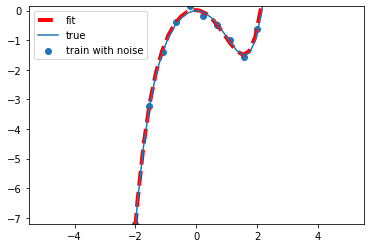

In [10]:
from sklearn.preprocessing import PolynomialFeatures


def func(x, scale=0.1):
    return 0.1*x**5-x**2+np.random.normal(loc=0.0, scale=scale, size=x.shape)


support_xtrain = np.expand_dims(np.linspace(-2, 2, num=10), 1)
x_train = support_xtrain
y_train = func(x_train).flatten()

max_polynomial = 5
polynomial_features = PolynomialFeatures(degree=max_polynomial)
xp = polynomial_features.fit_transform(x_train)
model = LinearRegression()
model.fit(xp, y_train)

support = np.expand_dims(np.linspace(-5, 5, num=50), 1)
x_test = polynomial_features.fit_transform(support)
ypred = model.predict(x_test)


plt.scatter(x_train, y_train, label="train with noise")
plt.plot(support, ypred, color="red", label="fit", linewidth=4, linestyle="--")
plt.plot(support, func(support, scale=0.0), label="true")
plt.legend()
plt.ylim([min(y_train), max(y_train)])

In [11]:
y_test = func(support).flatten()
mse, bias, var = bias_variance_decomp(
    model, xp, y_train, x_test, y_test, loss='mse', num_rounds=200, random_seed=1)
print("estimation: mse, bias, variance")
mse, bias, var

estimation: mse, bias, variance


(57930.82693373172, 171.89732083896624, 57758.92961289274)

# Pointwise Bias Variance Decomposition (on each support point)

In [18]:
# implementation for bias_variance_decomp with improved pointwise decomposition
# the idea is based on http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/
import copy


def compute_bias_variance_decomposition(model, x_train, y_train, x_test, y_test, num_resamples=400):
    '''
    The bias variance decomposition and the occuring expectation values are computed using bootstrap resamples.
    The function returns 
    * mse: the averaged squared error on the test set
    * bias_sq: the averaged squared bias of the predictions on the test set
    * variance: the averaged variance of the predictions on the test set
    * mse_per_support_point: the mse of the predictions per point on the test set
    * bias_sq_per_support_point: the squared bias of the predictions per point on the test set
    * variance_per_support_point: the variance of the predictions per point on the test set
    * models: A list of ''num_resamples'' fitted models
    '''
    indices = np.arange(0, len(x_train))
    y_preds = []
    models = []
    for i in range(num_resamples):
        resampled_indices = np.random.choice(
            indices, size=len(indices), replace=True)
        x_bootstrap = x_train[resampled_indices]
        y_bootstrap = y_train[resampled_indices]
        model.fit(x_bootstrap, y_bootstrap)
        models.append(copy.deepcopy(model))
        y_test_i = model.predict(x_test)
        y_preds.append(y_test_i)
    y_preds = np.array(y_preds)
    # this is a mean across the resamples '"here, average means "expectation of the training sets" not "expectation over examples in the training set"'

    mean_predictions_test = np.mean(y_preds, axis=0)
    bias_sq_per_support_point = (mean_predictions_test-y_test)**2
    variance_per_support_point = np.var(y_preds, axis=0)
    mse_per_support_point = np.mean((y_preds-y_test)**2, axis=0)

    # average over test set support points
    bias_sq = np.mean(bias_sq_per_support_point)
    variance = np.mean(variance_per_support_point)
    mse = np.mean(mse_per_support_point)

    return mse, bias_sq, variance, mse_per_support_point, bias_sq_per_support_point, variance_per_support_point, models

In [13]:
print("estimation: mse, bias, variance")
mse, bias, variance, mse_per_support_point, bias_sq_per_support_point, variance_per_support_point, models = compute_bias_variance_decomposition(
    model, xp, y_train, x_test, y_test, num_resamples=2000)
mse, bias, variance

estimation: mse, bias, variance


(40468.10499507641, 57.40891407863909, 40410.69608099781)

## Plot of fitted models
The compute_bias_variance_decomposition function returns all fitted models. This allows to obtain an intuitive understanding of the variance in the bias variance decomposition. The (pointwise) bias and variance are simply the bias and variance of the model (given a specific point) under different refits on bootstrapped training data. The variability for a model increases with higher order of the polynom, which is especially visible closer to the boundaries of the support.

Text(0, 0.5, 'model predictions')

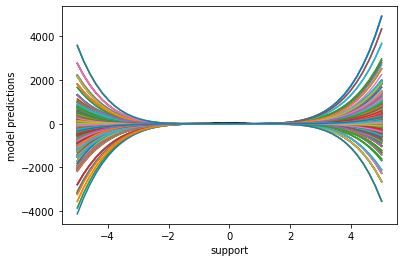

In [14]:
for model_i in models:
    plt.plot(support, model_i.predict(polynomial_features.transform(support)))
plt.plot(support, y_test)
plt.xlabel("support")
plt.ylabel("model predictions")

## Pointwise Bias and Variance Statistics

Text(0.5, 0, 'x')

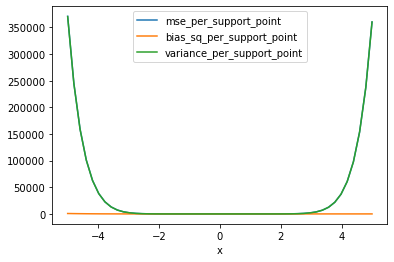

In [15]:
plt.plot(support, mse_per_support_point, label="mse_per_support_point")
plt.plot(support, bias_sq_per_support_point, label="bias_sq_per_support_point")
plt.plot(support, variance_per_support_point,
         label="variance_per_support_point")
plt.legend()
plt.xlabel("x")

# Bias Variance Decomposition in Dependence of Model Capacity

In [16]:
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

capacities = []
mses = []
biases = []
vars = []
for max_polynomial in range(1, 20):
    polynomial_features = PolynomialFeatures(degree=max_polynomial)
    # make_pipeline(StandardScaler(with_mean=True), linear_model.Lasso(alpha=1.0))
    model = LinearRegression()
    support = np.expand_dims(np.linspace(-5, 5, num=100), 1)
    x_test = polynomial_features.fit_transform(support)
    y_test = func(support).flatten()
    x_train = polynomial_features.fit_transform(support_xtrain)
    mse, bias, var = bias_variance_decomp(
        model, x_train, y_train, x_test, y_test, loss='mse', num_rounds=400, random_seed=1)
    capacities.append(max_polynomial)
    mses.append(mse)
    biases.append(bias)
    vars.append(var)

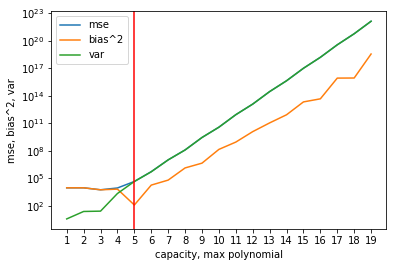

In [17]:
plt.plot(capacities, mses, label="mse")
plt.plot(capacities, biases, label="bias^2")
plt.plot(capacities, vars, label="var")
plt.xticks(capacities)
plt.xlabel("capacity, max polynomial")
plt.ylabel("mse, bias^2, var")  # averaged over support
plt.yscale("log")
plt.axvline(5, color="red")
plt.legend()